In [1]:
import autograd
import autograd.numpy as np
import scipy as sp

import copy
from scipy import optimize

import matplotlib.pyplot as plt
%matplotlib inline

In [140]:

# Neyman-Scott log probability for a single observation pair
def log_prob(z, log_theta, x1, x2):
    return log_prob_info(z, np.exp(-1. * log_theta), x1, x2)

# Neyman-Scott log probability for a single observation pair parameterized by the info.
def log_prob_info(z, nu, x1, x2):
    return log_prob_suff_stats(z, z**2, nu, np.log(nu), x1, x2) 

def log_prob_suff_stats(z, z2, nu, log_nu, x1, x2):
    return -0.5 * nu * (x1**2 + x2**2 + 2 * z * (x1 + x2) + 2 * z2) + log_nu



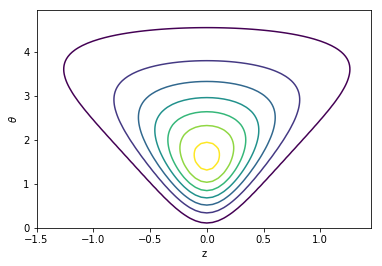

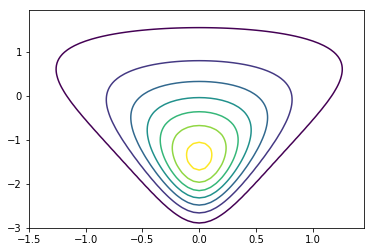

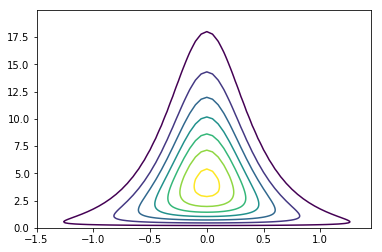

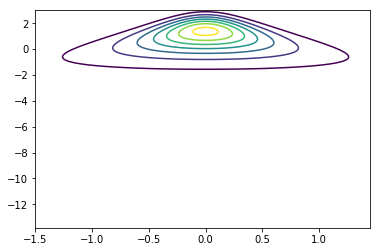

In [188]:
x1 = 0.5
x2 = -0.5
z_grid_points_lin = np.arange(-1.5, 1.5, 0.05)
log_theta_grid_points_lin = np.arange(-3., 2., 0.05)
log_theta_grid, z_grid = np.meshgrid(log_theta_grid_points_lin, z_grid_points_lin)
theta_grid_points_lin = np.arange(0.00001, 5., 0.05)
theta_grid, z_grid2 = np.meshgrid(theta_grid_points_lin, z_grid_points_lin)


lp = log_prob(z_grid, log_theta_grid, x1, x2)

plt.figure()
plt.contour(z_grid2, theta_grid, np.exp(lp))
plt.xlabel('z')
plt.ylabel('$\\theta$')


plt.figure()
plt.contour(z_grid, log_theta_grid, np.exp(lp))

nu_grid_points_lin = np.arange(0.000001, 20., 0.05)
nu_grid, z_grid2 = np.meshgrid(nu_grid_points_lin, z_grid_points_lin)
info_lp = log_prob_info(z_grid2, nu_grid, x1, x2)

plt.figure()
plt.contour(z_grid2, nu_grid, np.exp(info_lp))

plt.figure()
plt.contour(z_grid2, np.log(nu_grid), np.exp(info_lp))

In [145]:
import progress

class GibbsSampler(object):
    def __init__(self, x1, x2):
        self.x1 = x1
        self.x2 = x2
        self.lp_z_grad = autograd.grad(self.lp_z)
        self.lp_nu_grad = autograd.grad(self.lp_nu)

    # Log probability for the z draw
    def lp_z(self, z_suff_stats, nu):
        return log_prob_suff_stats(z_suff_stats[0], z_suff_stats[1], nu, np.log(nu), self.x1, self.x2)

    # Log probability for the nu draw
    def lp_nu(self, nu_suff_stats, z):
        return log_prob_suff_stats(z, z**2, nu_suff_stats[0], nu_suff_stats[1], self.x1, self.x2)

    def draw_z_given_nu(self, nu):
        # The value of z doesn't matter since the log probability is linear in the
        # sufficient statistics.
        z_nat_params = self.lp_z_grad([0., 0.], nu)
        z_var = -0.5 / z_nat_params[1]
        z_mean = z_nat_params[0] * z_var
        return np.random.normal(loc=z_mean, scale=np.sqrt(z_var), size=1)[0]
    
    def draw_nu_given_z(self, z):
        # The value of nu doesn't matter since the log probability is linear in the
        # sufficient statistics.
        nu_nat_params = self.lp_nu_grad([0., 0.], z)
        nu_shape = nu_nat_params[1] + 1
        nu_scale = -1. / nu_nat_params[0]
        return np.random.gamma(shape=nu_shape, scale=nu_scale, size=1)[0]
    
    def run_sampler(self, num_burnin, num_samples):
        nu_draws = []
        z_draws = []
        nu = 2.0
        z = 0.0
        
        # http://progressbar-2.readthedocs.io/en/latest/examples.html
        bar = progressbar.ProgressBar(max_value=num_burnin + num_samples)
        bar.start()
        for i in range(num_burnin + num_samples):
            bar.update(i)
            nu = self.draw_nu_given_z(z)
            z = self.draw_z_given_nu(nu)
            if i > num_burnin:
                z_draws.append(z)
                nu_draws.append(nu)
        bar.finish()
        return np.array(nu_draws), np.array(z_draws)


In [182]:
gibbs_sampler = GibbsSampler(x1, x2)
nu_fixed_z_draws = np.array([ gibbs_sampler.draw_nu_given_z(0.5 * (x1 + x2)) for i in range(5000) ])
nu_draws, z_draws = gibbs_sampler.run_sampler(5000, 20000)

100% (25000 of 25000) |###################| Elapsed Time: 0:00:12 Time: 0:00:12


Mean nu with fixed z:  8.0572989431
Means:			 -0.00371425037628 5.95001555766
Standard errors:	 0.00341762548737 0.0346075590615


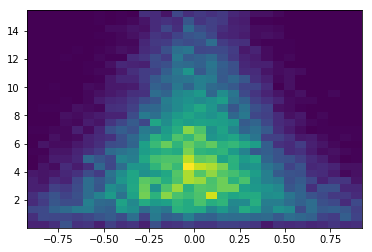

In [184]:
keep_rows = np.logical_and(
    np.abs(z_draws) < np.percentile(np.abs(z_draws), 95),
    nu_draws < np.percentile(nu_draws, 95))
plt.figure()
plt.hist2d(z_draws[keep_rows], nu_draws[keep_rows], bins=30);

# You can see that there are two things going on: the MAP is different from
# the mean, and fixing z is different from integrating over z.
print('Mean nu with fixed z: ', np.mean(nu_fixed_z_draws))

print('Means:\t\t\t', np.mean(z_draws), np.mean(nu_draws))
print('Standard errors:\t',
      np.std(z_draws) / np.sqrt(len(z_draws)),
      np.std(nu_draws) / np.sqrt(len(nu_draws)))

In [177]:
def log_prob_wrapper(par):
    z = par[0]
    nu = par[1]
    if nu <= 0.:
        return float('inf')
    return -1 * log_prob_info(z, nu, x1, x2)


lp_opt = sp.optimize.minimize(log_prob_wrapper, method='Nelder-Mead', x0=[0.1, 0.2])
print(lp_opt.x)

# We expect:
print('Expected and actual z optimum: ', 0.5 * (x2 + x1), lp_opt.x[0])
print('Expected and actual nu optimum: ', 4.0 / (x2 - x1)**2, lp_opt.x[1])

log_prob_wrapper_hessian = autograd.hessian(log_prob_wrapper)
lp_hess = log_prob_wrapper_hessian(lp_opt.x)
lp_hess_cov = np.linalg.inv(lp_hess)

[  4.10592762e-07   3.99996545e+00]
Expected and actual z optimum:  0.0 4.10592761527e-07
Expected and actual nu optimum:  4.0 3.99996544813


In [171]:
def kl_divergence(e_z, e_z2, nu_shape, nu_rate):
    z_var = e_z2 - e_z**2
    z_entropy = 0.5 * np.log(z_var)
    
    e_nu = nu_shape / nu_rate
    e_log_nu = sp.special.digamma(nu_shape) - np.log(nu_rate)
    nu_entropy = nu_shape - np.log(nu_rate) + sp.special.gammaln(nu_shape) + \
                 (1 - nu_shape) * sp.special.digamma(nu_shape)
    e_log_prob = log_prob_suff_stats(e_z, e_z2, e_nu, e_log_nu, x1, x2)
    
    return -1 * (e_log_prob + nu_entropy + z_entropy) 

def unwrap_vb_params(par):
    e_z = par[0]
    e_z2 = par[1]
    nu_shape = par[2]
    nu_rate = par[3]
    return e_z, e_z2, nu_shape, nu_rate

def kl_wrapper(par):
    e_z, e_z2, nu_shape, nu_rate = unwrap_vb_params(par)
    if nu_shape <= 0 or nu_rate <= 0 or e_z2 <= e_z**2:
        return float('inf')
    return kl_divergence(e_z, e_z2, nu_shape, nu_rate)

kl_opt = sp.optimize.minimize(kl_wrapper, method='Nelder-Mead', x0=[0.0, 1.0, 0.2, 0.2])
e_z, e_z2, nu_shape, nu_rate = unwrap_vb_params(kl_opt.x)
print(e_z, nu_shape / nu_rate)


2.59928256327e-06 6.00004652187


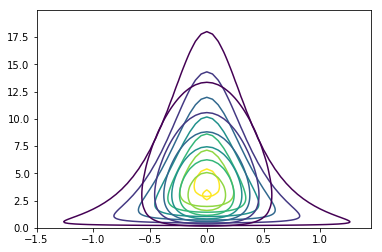

In [176]:
def q_log_prob(z, nu, par):
    e_z, e_z2, nu_shape, nu_rate = unwrap_vb_params(par)
    z_var = e_z2 - e_z**2
    log_q_z = -0.5 * ((z - e_z)**2) / z_var - 0.5 * np.log(z_var)
    log_q_nu = (nu_shape - 1) * np.log(nu) - nu_rate * nu - sp.special.gammaln(nu_shape) + nu_shape * np.log(nu_rate)
    return log_q_z + log_q_nu

qlp = q_log_prob(z_grid2, nu_grid, kl_opt.x)

plt.figure()
plt.contour(z_grid2, nu_grid, np.exp(info_lp))
plt.contour(z_grid2, nu_grid, np.exp(qlp))